## LSTM 

In [1]:
## for data
import json
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk
from nltk.tokenize import word_tokenize
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

C:\Users\Dee\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv("hausa_newsclass/train_clean.tsv", sep='\t')
df1 = pd.read_csv("hausa_newsclass/test.tsv", sep='\t')
df2 = pd.read_csv("hausa_newsclass/dev.tsv", sep='\t')
frames = [df, df1, df2]
df = pd.concat(frames)

In [3]:
df['label'].unique()

array(['Politics', 'Health', 'World', 'Nigeria', 'Africa'], dtype=object)

In [4]:
df['label'].unique()

array(['Politics', 'Health', 'World', 'Nigeria', 'Africa'], dtype=object)

In [5]:
df = df.replace("Nigeria", "Politics")
df = df.replace("Africa", "World")

In [6]:
df['label'].unique()

array(['Politics', 'Health', 'World'], dtype=object)

In [7]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    no_integers = [x for x in lst_text if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    text = " ".join(no_integers)
    return text

    

In [8]:
#lst_stopwohttp://localhost:8888/notebooks/TEXT%20CLASSIFICATION%20PROJECT/Text%20Summarization%20with%20LSTM-Yoruba.ipynb#rds = nltk.corpus.stopwords.words("german")
#lst_stopwords

#nltk.download('stopwords')
lst_stopwords = pd.read_csv('ha.txt', header=None)
lst_stopwords = np.array(lst_stopwords[0])
#lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

array(['ta', 'da', 'ya', 'sai', 'ba', 'yi', 'na', 'kuma', 'ma', 'ji',
       'cikin', 'in', 'ni', 'wata', 'wani', 'ce', 'tana', 'don', 'za',
       'sun', 'amma', 'ga', 'ina', 'ne', 'mai', 'suka', 'wannan', 'a',
       'ko', 'lokacin', 'su', 'take', 'shi', 'yake', 'yana', 'ka', 'ban',
       'ita', 'tafi'], dtype=object)

In [9]:
#nltk.download('wordnet')
df["text_clean"] = df["news_title"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.to_csv('data_hausa_cleaned.csv')

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text_clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['text_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Found 3783 unique tokens.
Shape of data tensor: (2917, 250)


In [11]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
Y = lb.fit_transform(df['label'])

In [12]:
lb.classes_

array(['Health', 'Politics', 'World'], dtype=object)

In [13]:
#Y = pd.get_dummies(dtf['category']).values
#print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#The first layer is the embedded layer that uses 100 length vectors to represent each word.
#SpatialDropout1D performs variational dropout in NLP model_hausas.
#The next layer is the LSTM layer with 100 memory units.
#The output layer must create 13 output values, one for each class.
#Activation function is softmax for multi-class classification.
#Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

model_hausa = Sequential()
model_hausa.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_hausa.add(SpatialDropout1D(0.2))
model_hausa.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_hausa.add(Dense(13, activation='softmax'))
model_hausa.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_hausa.summary())

epochs = 50
batch_size = 20

history = model_hausa.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

(2625, 250) (2625,)
(292, 250) (292,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
119/119 [==============================] - 98s 741ms/step - loss: 1.1984 - accuracy: 0.4365 - val_loss: 0.9645 - val_accuracy: 0.6730
Epoch 2/50
119/119 [==============================] - 86

10/10 [==============================] - 1s 90ms/step - loss: 0.4217 - accuracy: 0.8767
Test set
  Loss: 0.422
  Accuracy: 0.877


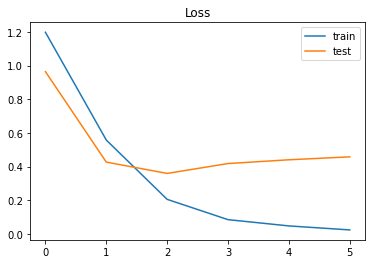

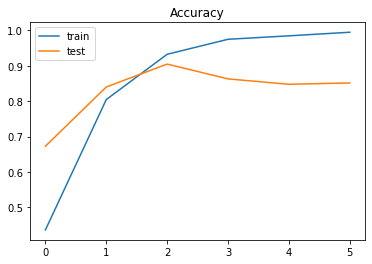

In [14]:
accr = model_hausa.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [15]:
df['text_clean'].iloc[100]

'yan bangar siyasa kai wa wasu kusoshin jamiyyar apc hari yola'

In [16]:
new_complaint = df['text_clean'].iloc[100]
seq = tokenizer.texts_to_sequences([new_complaint])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model_hausa.predict(padded)
labels = ['entertainment', 'health', 'politics', 'sport', 'world']
print(pred, labels[np.argmax(pred)])


[[2.7770252e-04 9.9842852e-01 1.1565273e-03 3.0098272e-06 2.8957997e-05
  1.1261172e-05 2.4951261e-05 1.0379720e-05 1.9959962e-05 1.3085657e-05
  9.7034235e-06 3.7813302e-06 1.2108303e-05]] health


In [17]:
model_hausa.save("model/LSTM_hausa.h5")

In [18]:
#Load KERAS model
from keras.models import load_model
# load model
model_hausa = load_model('model/LSTM_hausa.h5')

In [19]:
from sklearn.metrics import classification_report

y_pred = model_hausa.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test, y_pred_bool))

5/5 [==============================] - 2s 130ms/step
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        67
           1       0.81      0.89      0.85        99
           2       0.93      0.82      0.87       126

    accuracy                           0.88       292
   macro avg       0.88      0.89      0.88       292
weighted avg       0.88      0.88      0.88       292



In [20]:
lb.classes_

array(['Health', 'Politics', 'World'], dtype=object)

In [21]:
df

,news_title,label,text_clean
0,Atiku Abubakar Ya Kada Kuri'arsa A Jimeta A Ji...,Politics,atiku abubakar kada kuriarsa jimeta jihar adamawa
1,Kimanin mata dubu hamsin da biyar suke mutuwa ...,Health,kimanin mata dubu hamsin biyar suke mutuwa she...
2,Afghanistan: Masu Fashin Baki Sun Nuna Shakku ...,World,afghanistan masu fashin baki nuna shakku kan y...
3,Gwamnatin Kaduna Ta Gindaya Sharuddan Jinyar E...,Politics,gwamnatin kaduna gindaya sharuddan jinyar elza...
4,An Fara Yi Wa Jami’an Tsaron Najeriya Binciken...,Politics,an fara wa jamian tsaron najeriya binciken kwa...
...,...,...,...
285,Yadda Karin Albashi Ke Shafar Farashin Kayayyaki,Politics,yadda karin albashi ke shafar farashin kayayyaki
286,Ambaliyar Ruwan Tsunami Ta yi Barna A Indonesia,World,ambaliyar ruwan tsunami barna indonesia
287,Nigeriya Zata Sami Dala Biliyan Daya Daga Maga...,World,nigeriya zata sami dala biliyan daya daga maga...
288,Gwamnatin Kamaru Ta Tsare Sojoji 7 Da Ake Zarg...,World,gwamnatin kamaru tsare sojoji ake zargi kashe ...


In [ ]:
#Source of the dataset
#